In [1]:
Z_DIM = 10

### 1. Load Colored MNIST dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

# !pip install -q torchsummary
# from torchsummary import summary

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
# from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='../data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='../data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        self.T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            'img': self.T(ims),
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [4]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))
print(LABEL_SIZES)

60000 10000 4926
[10, 10, 10]


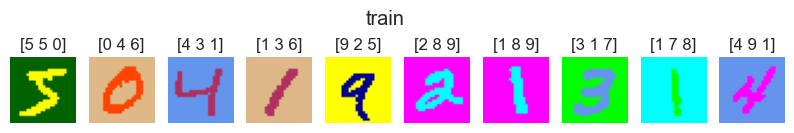

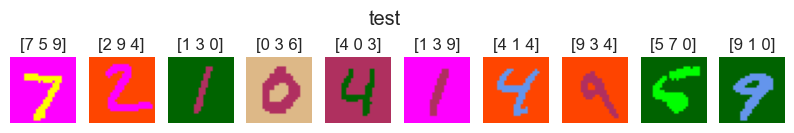

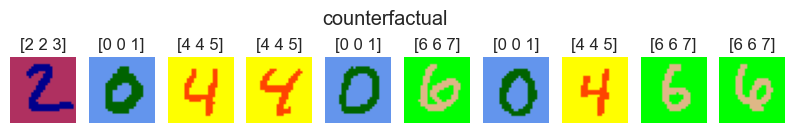

In [5]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [6]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

### 2. Build CVAE-GAN

In [7]:
def weights_init(model):
    ''' Инициализация весов генератора и дискриминатора '''

    classname = model.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

def get_one_hot(labels):
    new_ys = []
    for i, label_length in enumerate(LABEL_SIZES):
        new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
        new_ys.append(new_y)
    new_ys = torch.cat(new_ys, -1)
    return new_ys.to(torch.float32)

In [8]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Decoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Linear(z_dim+label_dim, 128*7*7),
            Reshape((-1, 128, 7, 7)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        data = torch.cat([z, get_one_hot(labels)], dim=1)
        prob_output = self.layers(data)
        return prob_output

class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(2304, z_dim)
        self.fc_output_scale = nn.Linear(2304, z_dim)

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        hidden = self.layers(data)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Discriminator(nn.Module):
    def __init__(self, label_dim=30, p=0.3):
        super(Discriminator, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 128, 5, 2, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(2304, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        return self.layers(data)

In [9]:
class CVAE_GAN(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim, label_dim=label_dim, p=p)
        self.discriminator_ = Discriminator(label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.device = 'cuda' if use_cuda else 'cpu'
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(z, labels)
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

            # is_real part
            prob_real = self.discriminator_(loc_img, labels).squeeze()
            prob_real = prob_real.expand([28*28*3, *prob_real.shape]).T
            ones = torch.full((x.shape[0],), 1., dtype=torch.float, device=self.device)
            ones = ones.expand([28*28*3, *ones.shape]).T
            pyro.sample("is_real", dist.Bernoulli(prob_real).to_event(1), obs=ones)

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def model_generate(self, batch_size):
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)
        with pyro.plate("data", batch_size):
            # pior for Z
            z_loc = torch.zeros(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z_scale = torch.ones(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z = dist.Normal(z_loc, z_scale).rsample()

            # random labels for generation
            rand_labels = torch.randint(low=0, high=10, size=(batch_size, 3), device=self.device)
            loc_img = self.decoder_(z, rand_labels)
            prob_real = self.discriminator_(loc_img, rand_labels).squeeze()
            ones = torch.full((batch_size,), 1., dtype=torch.float, device=self.device)
            pyro.sample("obs", dist.Bernoulli(prob_real), obs=ones)

    def guide_generate(self, batch_size):
        pass

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    def reconstruct_img(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

### 3. Load trained CVAE-GAN

In [10]:
pyro.clear_param_store()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = CVAE_GAN(p=0.2, use_cuda=torch.cuda.is_available())
vae.load_state_dict(torch.load('../../train_CVAEGAN/zdim=10/vaegan_zdim10_it1891.pt', map_location='cpu'))

<All keys matched successfully>

### 4. Load trained CAUSICA graph

In [11]:
### Using Zs in CAUSICA
vardist_mode = np.array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype='float32')

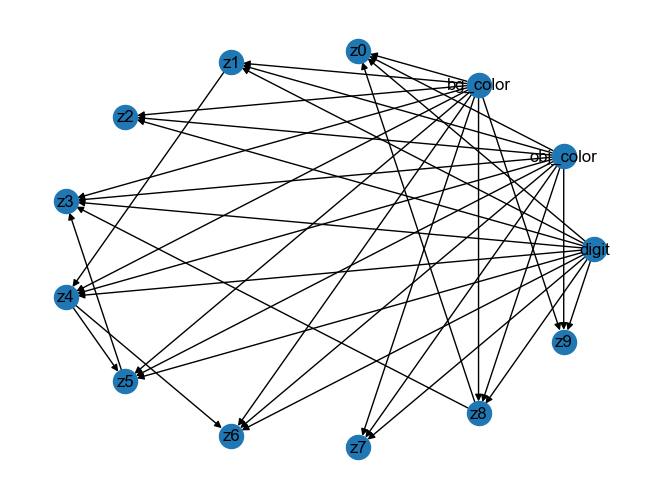

In [12]:
import networkx as nx
Z_DIM = 10
labeldict = {i: l for i, l in enumerate(['digit', 'obj_color', 'bg_color']+['z'+str(j) for j in range(Z_DIM)])}
graph = nx.from_numpy_array(vardist_mode, create_using=nx.DiGraph)
nx.draw_circular(graph, labels=labeldict, with_labels=True, arrows=True)

### 5. Use trained CAUSICA graph to build SCM

In [13]:
# Getting original image
batch = next(iter(test_loader))
scm_x = batch['img']
scm_y = batch['label']
scm_mu, scm_sigma = vae.encoder(scm_x, scm_y)

In [14]:
class SCM():
    def __init__(self, vardist_mode, z_dim=3, num_labels=3, label_sizes=LABEL_SIZES):
        pyro.clear_param_store()
        self.z_names = ['Z'+str(i) for i in range(z_dim)]
        self.var_names = np.array(['Y'+str(i+1) for i in range(num_labels)] + self.z_names)
        self.feat_dims = {k: ls for k, ls in zip(self.var_names, LABEL_SIZES + list(np.ones(z_dim, dtype=int)))}
        self.name_to_num = {k: i for i, k in enumerate(self.var_names)}
        self.vardist_mode = vardist_mode

    @staticmethod
    def get_onehot_bias(Y_parents, Z_parents):
        if len(Y_parents):
            BS = len(Y_parents[0])
        else:
            BS = len(Z_parents[0])
        onehot_bias = []
        for Y in Y_parents:
            onehot_bias.append(F.one_hot(Y.to(torch.int64), num_classes=10).float())
        for Z in Z_parents:
            onehot_bias.append(Z[:, None])
        onehot_bias.append(torch.ones(BS, 1))
        return torch.cat(onehot_bias, dim=1)

    def get_sample_model(self, sample_dict, a, var_name, obs_vectors, sigmas):
        if var_name in sample_dict:
            return sample_dict, a
        BS = len(list(sigmas.values())[0])
        num = self.name_to_num[var_name]
        parents = self.var_names[self.vardist_mode[:, num].astype(bool)]
        if len(parents) == 0:
            if var_name[0] != 'Y':
                a[var_name] = pyro.param('a_'+var_name,
                                        torch.rand((1, self.feat_dims[var_name])),
                                        #  constraint = constraints.interval(-10, 10)
                                        )
                var_mu = a[var_name].repeat(BS, 1)
        else:
            parent_dim = 1
            Y_parents, Z_parents = [], []
            for parent in parents:
                parent_dim += self.feat_dims[parent]
                sample_dict, a = self.get_sample_model(sample_dict, a, parent, obs_vectors, sigmas)
                if parent[0] == 'Y':
                    Y_parents.append(sample_dict[parent])
                elif parent[0] == 'Z':
                    Z_parents.append(sample_dict[parent])
            a[var_name] = pyro.param('a_'+var_name,
                                     torch.rand((parent_dim, self.feat_dims[var_name]))
                                     #  constraint = constraints.interval(-10, 10)
                                     )
            var_mu = self.get_onehot_bias(Y_parents, Z_parents) @ a[var_name]
        if var_name[0] == 'Y':
            # sample_dict[var_name] = pyro.sample(var_name, dist.Categorical(logits=var_mu), obs=obs_vectors[var_name])
            sample_dict[var_name] = obs_vectors[var_name]
        else:
            sample_dict[var_name] = pyro.sample(var_name, dist.Normal(var_mu.flatten(), sigmas[var_name]).to_event(1), obs=obs_vectors[var_name])
        return sample_dict, a

    def model(self, sigma, mu, labels):
        sample_dict = {}
        a = {}
        BS = len(sigma)
        sigmas = {k: val for k, val in zip(self.z_names, sigma.T)}
        obs_vectors = {k: val for k, val in zip(self.var_names, torch.cat([labels, mu], dim=1).T)}
        with pyro.plate("data", BS):
            for var_name in self.var_names:
                if var_name not in sample_dict:
                    sample_dict, a = self.get_sample_model(sample_dict, a, var_name, obs_vectors, sigmas)

    def guide(self, sigma, mu, labels):
        pass

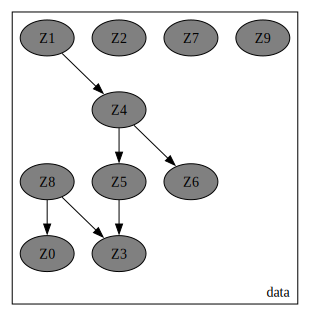

In [15]:
scm = SCM(vardist_mode, z_dim=10)
pyro.render_model(scm.model, model_args=(scm_sigma, scm_mu, scm_y))

In [16]:
pyro.render_model(scm.guide, model_args=(scm_sigma, scm_mu, scm_y))

In [17]:
def callback(train_elbo, last_params):
    size = (len(param_names) + 2) // 3
    f, ax = plt.subplots(size, 3, figsize=(16, size * 3))
    ax = ax.flatten()
    for i, (k, param) in enumerate(last_params.items()):
        sns.heatmap(param, ax=ax[i], annot=True, fmt=".1f" if i == 2 else ".2f")
        ax[i].set_title(k)
    plt.tight_layout()

    epoch = len(train_elbo)
    clear_output(wait=True)
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    plt.xlabel('iteration')
    plt.title(f'Iteration {epoch}. Train ELBO {train_elbo[-1]}')
    plt.show()

In [18]:
pyro.clear_param_store()

adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

svi = SVI(
    model=scm.model,
    guide=scm.guide,
    optim=optimizer,
    loss=Trace_ELBO(retain_graph=True)
)

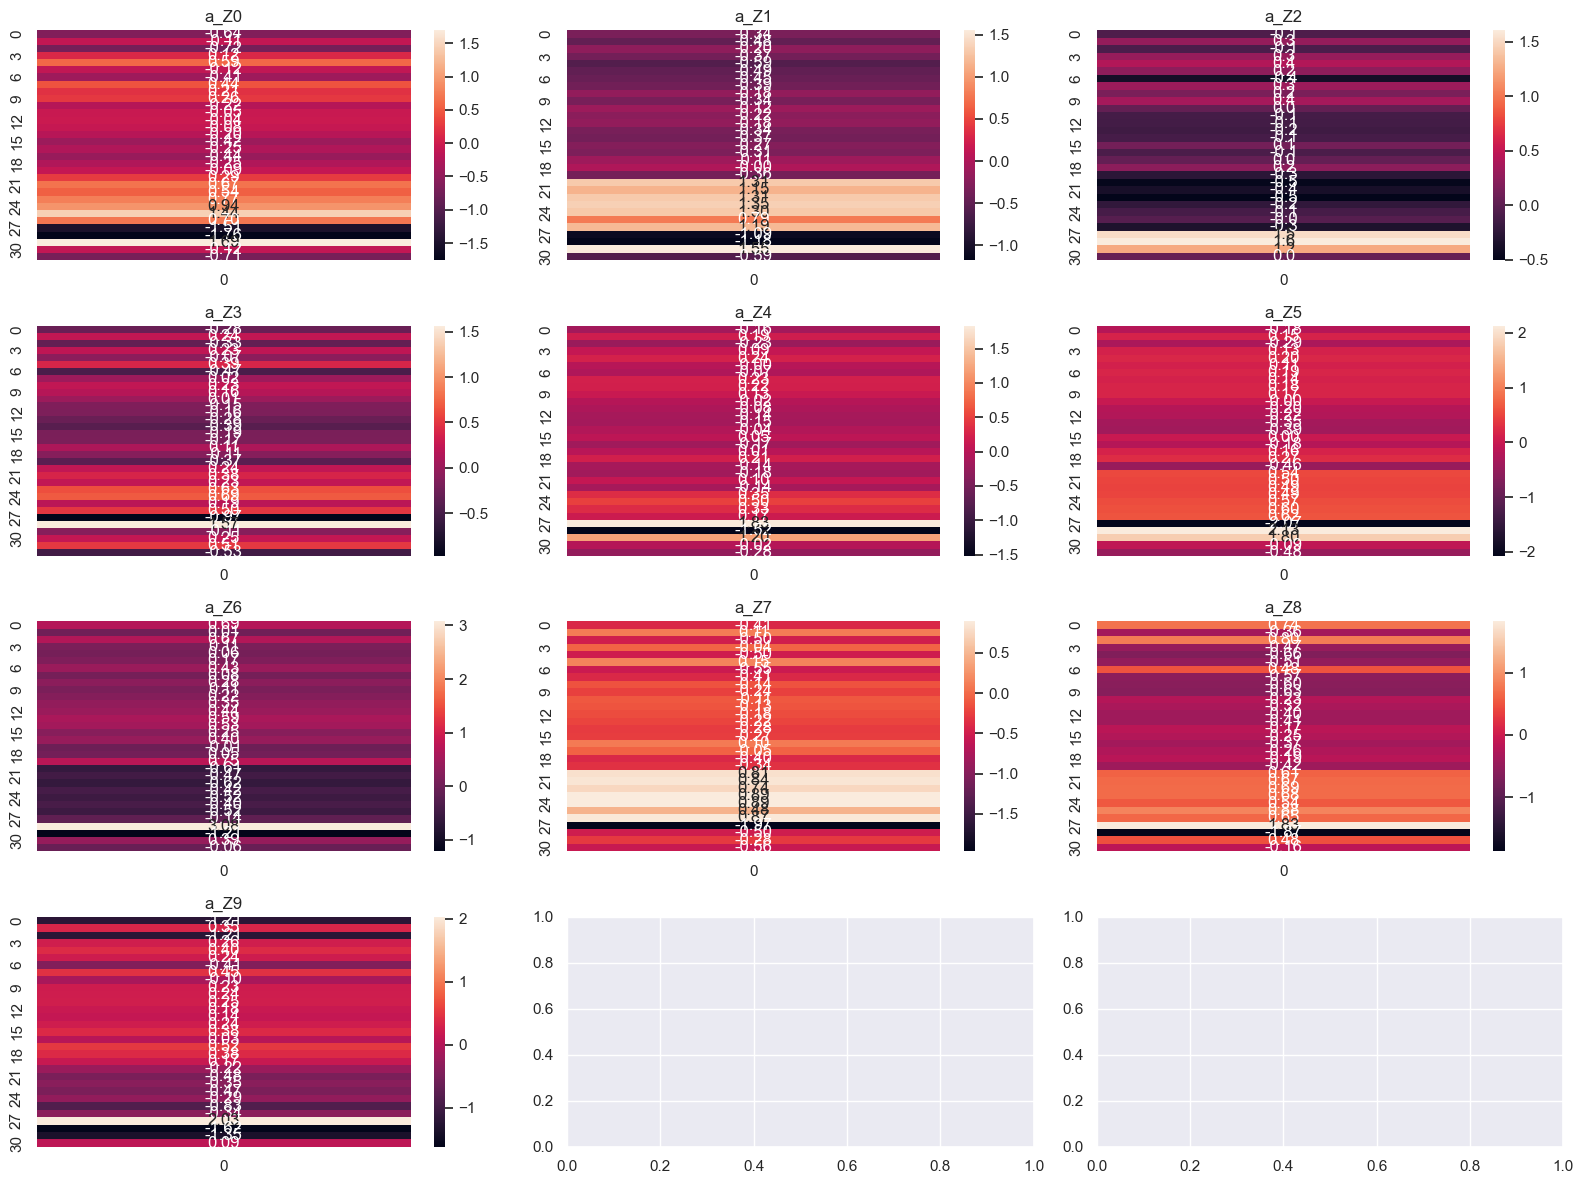

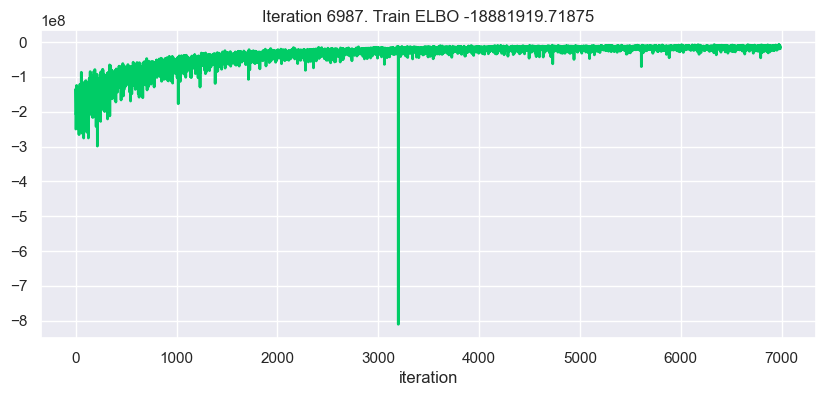

100%|████████████████████████████████████████| 30/30 [1:49:19<00:00, 218.66s/it]


In [19]:
num_steps = 30
param_names = ['a_Z'+str(j) for j in range(Z_DIM)]
ELBO_hist = []
last_params = {}

for epoch in tqdm(range(num_steps)):
    for i, batch in enumerate(train_loader):
        scm_x = batch['img']
        scm_y = batch['label']
        scm_mu, scm_sigma = vae.encoder(scm_x, scm_y)
        loss = svi.step(scm_sigma, scm_mu, scm_y)
        ELBO_hist.append(-loss)
        if i % 100 == 0:
            for param_name in param_names:
                last_params[param_name] = pyro.param(param_name).detach().cpu()
            callback(ELBO_hist, last_params)

In [20]:
import pickle
with open('params_zdim10_gan_reg.pkl', "wb") as f:
    pickle.dump(last_params, f)